# Frequency Distributions
Throughout the course we've encountered problems where we wanted to distribute some property with a given frequency (e.g., connected nodes in a graph, or occupied cells in an array). In these cases, we typically used a random number generator to generate the distribution of outcomes for a fixed probability, $p$, of the property occurring.
Similarly, we've seen how a stochastic process, like the ignition of a fire or regeneration of a forested cell, can be modelled using a random number generator to generate occurrences with a fixed frequency (e.g., 0.001 representing an occurrence in 1 out of 1000 "trials").

These are examples of "[discrete random variables](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/04%3A_Discrete_Random_Variables/4.01%3A_Random_Variables)".  When you repeat an experiment with a random variable many times, you end up with a "[distribution](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/04%3A_Discrete_Random_Variables/4.02%3A_Probability_Distributions_for_Discrete_Random_Variables)" of outcomes, which describes the frequency or probability of each outcome.

[Descriptive Statistics](https://en.wikipedia.org/wiki/Descriptive_statistics) provides a framework for the mathematical analysis of random variables, probability, and [frequency distributions](https://en.wikipedia.org/wiki/Frequency_(statistics)).

Here we will use computation to gain some intuition about the relationship between random variables and the distributions they generate.  We will use these insights to examine "[heavy-tailed distribution](https://en.wikipedia.org/wiki/Heavy-tailed_distribution)" and try to understand why these may be the signature of systems with "[self-organization](https://en.wikipedia.org/wiki/Self-organization)".

As usual, the first code block just imports the modules we will use.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Frequency Distribution
When we make a large number of observations arising from a process, it is often useful to examine the frequency of the observed values. For example:
* when flipping a coin, what is the frequency of heads vs. tails?
* when rolling a pair of dice, what is the frequency of rolling each total: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12?
* when grading papers, what is the frequency of test scores?
* when trialling a new vaccine, what is the frequency of a given side-effect?
* etc.

Since different processes result in distributions with distinct shapes, the shape of a distribution gives us clues or evidence about the underlying process that generated the observations.

### Uniform Distribution
A uniform distribution arises when each observation has the same probability, p, of occuring.   Examples would be flipping a coin (p = 0.5) or rolling a 6-sided die (p = 1/6)...

p(heads)= 0.5048  p(tails)= 0.4952


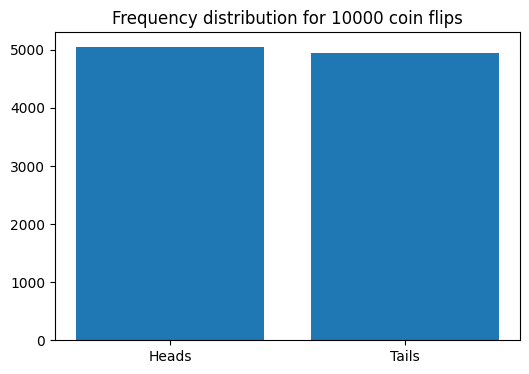

In [2]:
def flip():
    """ simulate a coin flip, return True if heads, False if tails """
    return np.random.random() < 0.5

n_tosses = 10000
tosses = [flip() for i in range(n_tosses)]
heads = sum(1 for t in tosses if t)
tails = n_tosses - heads
print("p(heads)=", heads/n_tosses, " p(tails)=",tails/n_tosses)

_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title(f"Frequency distribution for {n_tosses} coin flips")
ax.bar(('Heads', 'Tails'), (heads, tails))
plt.show()

### Non-uniform Distributions
A non-uniform distribution arises when the frequency of each outcome is distinct.  For example, players of dice games like [Craps](https://en.wikipedia.org/wiki/Craps) or [D&D](https://en.wikipedia.org/wiki/Dungeons_%26_Dragons) will know that rolling double-ones (snake-eyes) or double-sixes is an infrequent occurrence, i.e., it has a low probability  ...

['p(2)=", 279/10000', 'p(3)=", 585/10000', 'p(4)=", 887/10000', 'p(5)=", 1091/10000', 'p(6)=", 1404/10000', 'p(7)=", 1646/10000', 'p(8)=", 1381/10000', 'p(9)=", 1085/10000', 'p(10)=", 805/10000', 'p(11)=", 546/10000', 'p(12)=", 291/10000']


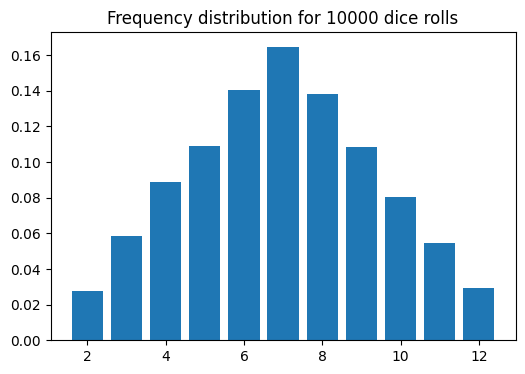

In [3]:
def roll(sides=6):
    """ simulate an n-sided dice roll.  Return int value on die face. """
    return np.random.choice(range(1, sides+1))

def roll_dice(n_dice=2, sides=6):
    """ simulate rolling n dice and return the sum of their face values """
    return sum(roll(sides) for r in range(n_dice))

n_rolls = 10000
rolls = [roll_dice() for i in range(n_rolls)]
outcomes = sorted(set(rolls))
counts = np.array([sum(1 for r in rolls if r == o) for o in outcomes])

print([f'p({o})=", {n}/{n_rolls}' for o, n in zip(outcomes, counts)] )

_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title(f"Frequency distribution for {n_rolls} dice rolls")
ax.bar(outcomes, counts/n_rolls)
plt.show()

p(edge)=299314/999000, p(no_edge)= 699686/999000


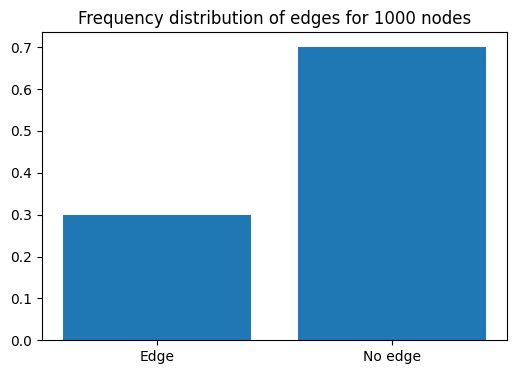

In [4]:
def connect(p):
    """ return True if 2 nodes should be connected, with a probability, p """
    return np.random.random() < p

p = 0.3
n_nodes = 1000
potential_edges = n_nodes*(n_nodes-1)
edges = [connect(p) for i in range(potential_edges)]
connected = sum(1 for e in edges if e)
disconnected = potential_edges - connected
print(f'p(edge)={connected}/{potential_edges}, p(no_edge)= {disconnected}/{potential_edges}')

_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title(f"Frequency distribution of edges for {n_nodes} nodes")
ax.bar(('Edge', 'No edge'), (connected/potential_edges, disconnected/potential_edges))
plt.show()

### A Frequency Distribution Class
You might notice some code duplicated in each of the experiments above to take convert the experimental observations, compute the frequency distribution, and plot it.  Let's package that logic up for re-use.

Note: the textbook author published a more full-featured (and efficient!) version of this class called [empiricaldist](https://nbviewer.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb) on [PyPi](https://pypi.org/project/empiricaldist/)

In [5]:
class FrequencyDist:
    """ Represents the Frequency Distribution for a set of observations on a discrete random variable """
    def __init__(self, observations, labels: dict=None, title='Trials'):
        """ observations is a 1D sequence of empirical data, labels optionally relabel observation values """
        self.n_obs = len(observations)
        self.title = title
        # sort categories in same order as labels dict, if provided
        key = (lambda v: list(labels.keys()).index(v)) if labels else None
        self.categories = sorted(set(observations), key=key)
        self.n_cat = len(self.categories)

        # frequencies and matching category labels
        self.counts = np.array([sum(1 for sample in observations if sample == category) for category in self.categories])
        self.proportions = self.counts/self.n_obs
        self.category_labels = tuple(labels[c] for c in self.categories) if labels else self.categories

    def get_frequencies(self):
        """ Return the frequency count of each category as a dict """
        return {
            cat: freq for cat, freq in zip(self.category_labels, self.counts)
        }

    def print_frequencies(self):
        """ Print the frequency of each category as a fraction of observations """
        print(f'{self.title}:', [f'p({o})=", {n}/{self.n_obs}' for o, n in self.get_frequencies().items()] )

    def bar(self, axes=None, **options):
        """ Plot distribution as a bar chart. """
        axes = axes or plt.gca()  # If no axes are provided, draw on current axes
        axes.set(**options)
        axes.set_title(f'Frequency distribution for {self.n_obs} {self.title}')
        axes.bar(self.category_labels, self.proportions)

    def plot(self, axes=None, **options):
        """ Plot distribution as a line graph. """
        axes = axes or plt.gca()  # If no axes are provided, draw on current axes
        axes.set(**options)
        axes.set_title(f'Frequency distribution for {self.n_obs} {self.title}')
        axes.plot(self.categories, self.proportions)

Node Pairs: ['p(Edge)=", 299314/999000', 'p(No Edge)=", 699686/999000']
Rolls: ['p(2)=", 279/10000', 'p(3)=", 585/10000', 'p(4)=", 887/10000', 'p(5)=", 1091/10000', 'p(6)=", 1404/10000', 'p(7)=", 1646/10000', 'p(8)=", 1381/10000', 'p(9)=", 1085/10000', 'p(10)=", 805/10000', 'p(11)=", 546/10000', 'p(12)=", 291/10000']


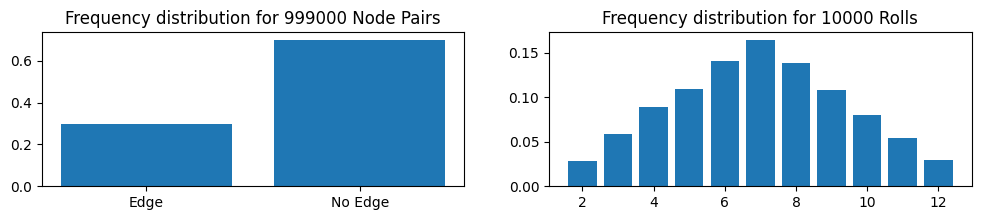

In [6]:
# Tests
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2))

d = FrequencyDist(edges, labels={True:'Edge', False:'No Edge'}, title="Node Pairs")
d.print_frequencies()
d.bar(axes=ax1)

d = FrequencyDist(rolls, title="Rolls")
d.print_frequencies()
d.bar(axes=ax2)
plt.show()

## Geometric distribution
A geometric distribution is the discrete cousin of the exponential distribution.  The most common observations are small-valued, and the number of observations drops off geometrically (exponentially) as observations get larger.  [https://en.wikipedia.org/wiki/Geometric_distribution](https://en.wikipedia.org/wiki/Geometric_distribution)
 Plotted on a linear scale, the shape of this distribution is analogous to exponential decay, asymtoptic to the x-axis.
 Plotted on a log scale, the distribution forms a straight line with a negative slope.

### Experiment:
Flip a coin and count the length of each "run on heads" (number of heads in a row)

In [7]:
def run_length():
    """ Flip a coin until Heads and continue to flip until Tails, return the number of heads in the run """
    while not flip():
        pass
    run = 1
    while flip():
        run += 1
    return run


def experiment(n):
    """ Run a coin flip experiment with n trials, return np.array with run length for each trial """
    trials = np.zeros(n, dtype='uint8')
    for i in range(n):
        trials[i] = run_length()
    return trials

print("Length of runs on Heads:")
experiment(10)

Length of runs on Heads:


array([4, 2, 4, 1, 1, 2, 3, 3, 2, 1], dtype=uint8)

If we interpret tossing "Tails" as a "success", then the length of a run-on-heads is "the number failures before success".
This yields the classic definition of a [Geometric Distribution](https://en.wikipedia.org/wiki/Geometric_distribution) with p = 0.5

10000 Trials: Avg. run length 1.9977  Max. run length: 15
Trials: ['p(1)=", 4962/10000', 'p(2)=", 2514/10000', 'p(3)=", 1276/10000', 'p(4)=", 640/10000', 'p(5)=", 329/10000', 'p(6)=", 139/10000', 'p(7)=", 70/10000', 'p(8)=", 33/10000', 'p(9)=", 21/10000', 'p(10)=", 10/10000', 'p(11)=", 2/10000', 'p(13)=", 2/10000', 'p(14)=", 1/10000', 'p(15)=", 1/10000']


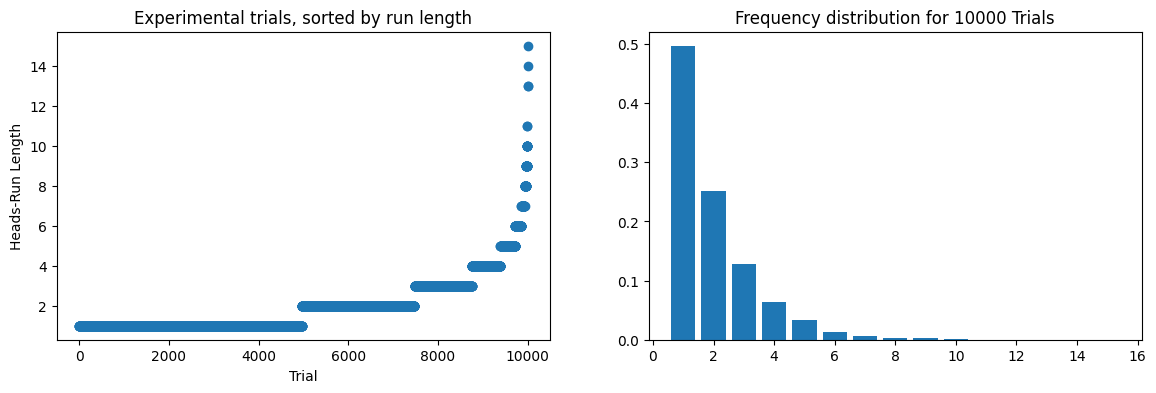

In [8]:
n_trials = 10000
trials = experiment(n_trials)

mean_run = trials.mean()
max_run = trials.max()

print(n_trials, 'Trials: Avg. run length', mean_run, ' Max. run length:', max_run)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(sorted(trials), 'o')
ax1.set_title("Experimental trials, sorted by run length")
ax1.set_xlabel('Trial')
ax1.set_ylabel('Heads-Run Length')

dist = FrequencyDist(trials)
dist.print_frequencies()
dist.bar(axes=ax2)

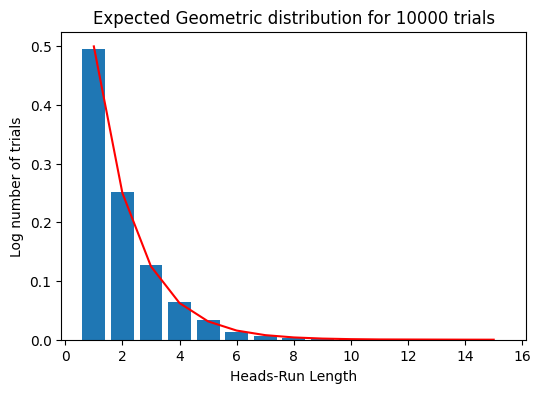

In [9]:
# predicted geometric sequence for run lengths - each bin has 1/2 of the remaining tosses.
ys = np.array([1/2**i for i in range(1, dist.n_cat+1)])  # p(n) = 1/2**n

_, ax = plt.subplots(1, 1, figsize=(6, 4))

dist.bar(axes=ax)

# ax.bar(outcomes, counts)
ax.plot(dist.categories, ys, color='red')
#ax.set_yscale("log")
ax.set_title(f"Expected Geometric distribution for {dist.n_obs} trials")
ax.set_xlabel("Heads-Run Length")
ax.set_ylabel("Log number of trials")
plt.show()

# Heavy-tailed distributions
A "heavy-tail" (or "long-tailed") distribution has a similar shape to a geometric or exponential distribution, except that the probability of observaions out in the "tail" are more frequent that predicted by a purely geometric sequence.
A heavy-tailed distribution decays slower, so lies above a geometric or exponential distribution with the same mean.
[Many natural processes](https://en.wikipedia.org/wiki/Power_law#Examples) are observed to have "heavy-tailed" distributions, for example:
 * wealth distribution
 * forest fire size
 * earthquake magnitude
 * file sizes
